### Behind the scenes: building the model 

Data of 26,423 dogs available for adoption within 100 miles of New York (zipcode 10001) between January and May 2023. Clean dataframe is a result of merging (a) biographies (column: `text`) scraped from individual dog profile pages and (b) data available via Petfinder API. 

Model takes gender, size, age group, breed(s), traits (`tags`), and text as inputs and predicts how likely a dog will be adopted within one month. 

In [1]:
# import libraries and tools 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import dill 

from preprocess import TagCleaner, DictEncoder
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler 
from sklearn.base import BaseEstimator, TransformerMixin 
from sklearn.feature_extraction import DictVectorizer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.compose import ColumnTransformer 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.pipeline import Pipeline 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [2]:
# load data 
with open('data_main_v6.pkd', 'rb') as file:
    data = dill.load(file)

In [3]:
# preview the data, check dataframe has the expected columns
data.head()

,id,gender,tags,age_code,size_code,breed.1,breed.2,breed.mix,text,status_30d
0,59623998,F,[],0,2,Black Labrador Retriever,Weimaraner,1,Empty,0
1,59623994,F,"[Friendly, Brave, Couch potato, Curious, Loyal...",0,1,Golden Retriever,Great Pyrenees,1,Empty,0
2,59623941,M,[],0,2,Black Labrador Retriever,Weimaraner,1,Empty,0
3,59623710,M,[],2,2,Mixed Breed,Mixed Breed,1,Empty,0
4,59623708,F,[],2,1,Mixed Breed,Mixed Breed,1,Empty,0


In [4]:
# gut check for no missing data 

data.isna().sum()

id            0
gender        0
tags          0
age_code      0
size_code     0
breed.1       0
breed.2       0
breed.mix     0
text          0
status_30d    0
dtype: int64

In [5]:
# gut check that we have text data 

data[data['text'] != 'Empty'].shape

(21020, 10)

In [6]:
# gut check for balanced data 

data.groupby('status_30d').size()

status_30d
0    13421
1    13002
dtype: int64

In [7]:
# separate out X and y 

y = data['status_30d']
X = data.drop(columns=['status_30d'])

In [8]:
# split data into training and test sets 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

In [9]:
# assign columns for ColumnTransformer

ordinal = ['age_code', 'size_code']
categorical = ['gender', 'breed.1', 'breed.2']

In [10]:
# set up stopwords for TFIDF 

stop_words = stopwords.words('english')

In [11]:
# set up pipeline 
# hyperparameters are based on results from previous GridSearchCV 

steps_tags = Pipeline([
    ('clean', TagCleaner()), 
    ('de', DictEncoder()), 
    ('dv', DictVectorizer())
])

features = ColumnTransformer([
    ('ordinal', OrdinalEncoder(), ordinal), 
    ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical), 
    ('tags_dv', steps_tags, 'tags'), 
    ('text_tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), 
                                   min_df=10, max_df=0.8, max_features=5000), 'text')
])

model = Pipeline([
    ('features', features), 
    ('classifier', RandomForestClassifier(max_depth=500, random_state=33))
])

In [12]:
# train model 

model.fit(X_train, y_train)

Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('ordinal', OrdinalEncoder(),
                                                  ['age_code', 'size_code']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'breed.1',
                                                   'breed.2']),
                                                 ('tags_dv',
                                                  Pipeline(steps=[('clean',
                                                                   TagCleaner()),
                                                                  ('de',
                                                                   DictEncoder()),
                                                                  ('dv',
                                                                   DictVectorizer())]),
                                                  'tags'),
                                                 ('text_tfidf',
                                                  TfidfVectorizer(max_df=0.8,
                                                                  max_...
                                                                  min_df=10,
                                                                  ngram_range=(1,
                                                                               2),
                                                                  stop_words=['i',
                                                                              'me',
                                                                              'my',
                                                                              'myself',
                                                                              'we',
                                                                              'our',
                                                                              'ours',
                                                                              'ourselves',
                                                                              'you',
                                                                              "you're",
                                                                              "you've",
                                                                              "you'll",
                                                                              "you'd",
                                                                              'your',
                                                                              'yours',
                                                                              'yourself',
                                                                              'yourselves',
                                                                              'he',
                                                                              'him',
                                                                              'his',
                                                                              'himself',
                                                                              'she',
                                                                              "she's",
                                                                              'her',
                                                                              'hers',
                                                                              'herself',
                                                                              'it',
                                                                              "it's",
                                                 

In [13]:
# model accuracy on training data 

model.score(X_train, y_train)

0.9639038698079289

In [14]:
# model accuracy on test data 

model.score(X_test, y_test)

0.7142857142857143

In [15]:
# more metrics 

y_pred = model.predict(X_test)

prec = precision_score(y_test, y_pred, labels=model.classes_)
reca = recall_score(y_test, y_pred, labels=model.classes_)
f1 = f1_score(y_test, y_pred)

print('precision: ', prec)
print('recall: ', reca)
print('f1: ', f1)

precision:  0.6862676056338028
recall:  0.7589563862928349
f1:  0.7207840236686391


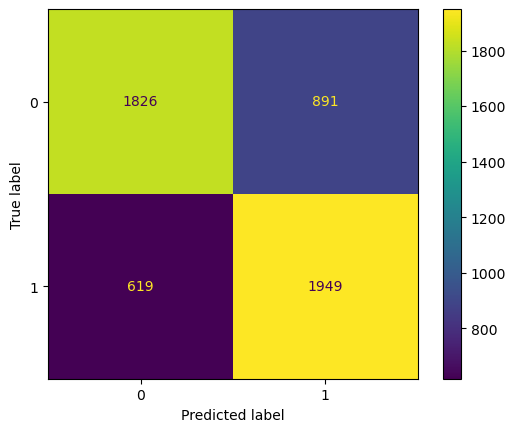

In [16]:
# confusion matrix 

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=model.classes_)
disp.plot()
plt.show()

In [17]:
# save model 

with open('model_final.pkd', 'wb') as file:
    dill.dump(model, file)

In [ ]:
# future directions 
# transform tags and text data into word embeddings 
# use scikit-survival for time-to-event analysis and predictions 
# try SHAP (SHapley Additive exPlanations) for better explanations on feature importance